In [1]:
# This file provide template to download and work with the TinyImageNet dataset

In [2]:
# Please make sure GPU is disabled for this inference part of the lab
# Disable GPU and enable xla flags
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'
import pathlib
import numpy as np
import tensorflow as tf
import os
import datetime
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import Model

2021-09-06 15:22:27.119334: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [3]:
# Make sure that unzipped tiny-imagenet-200 folder is placed in the current directory
#define path to the dataset
path = pathlib.Path('/local/tiny-imagenet-200')

In [4]:
# Map the wnids to integer labels to words
with open(os.path.join(path, 'wnids.txt'), 'r') as f:
  wnids = [x.strip() for x in f]


# Map wnids to integer labels
wnid_to_label = {wnid: i for i, wnid in enumerate(wnids)}
label_to_wnid = {v: k for k, v in wnid_to_label.items()}

# Use words.txt to get names for each class
with open(os.path.join(path, 'words.txt'), 'r') as f:
  wnid_to_words = dict(line.split('\t') for line in f)
  for wnid, words in wnid_to_words.items():
      wnid_to_words[wnid] = [w.strip() for w in words.split(',')]
class_names = [wnid_to_words[wnid] for wnid in wnids]

In [5]:
# Import necessary packages
from __future__ import print_function
from builtins import range
from six.moves import cPickle as pickle
import numpy as np
import os
import platform
from tqdm import tqdm
import random
from imageio import imread
from imageio import imsave


# Function for loading the tiny imagenet data
def load_tiny_imagenet(path, is_training=True, dtype=np.float32, subtract_mean=True, debug=False, debug_nclass=3):
    """
    Load TinyImageNet. Each of TinyImageNet-100-A, TinyImageNet-100-B, and
    TinyImageNet-200 have the same directory structure, so this can be used
    to load any of them.

    Note: The original implementation loaded data as NCHW, I (tyler) changed it to NHWC

    Inputs:
    - path: String giving path to the directory to load.
    - is_training: If True, dont load testing data, if False, dont load training and val data
        Note: Must always load training data in order to subtract_mean.
    - dtype: numpy datatype used to load the data.
    - subtract_mean: Whether to subtract the mean training image.
    - debug: Whether or not to load a small number of classes for debugging

    Returns: A dictionary with the following entries:
    - class_names: A list where class_names[i] is a list of strings giving the
      WordNet names for class i in the loaded dataset.
    - X_train: (N_tr, 64, 64, 3) array of training images
    - y_train: (N_tr,) array of training labels
    - X_val: (N_val, 64, 64, 3) array of validation images
    - y_val: (N_val,) array of validation labels
    - X_test: (N_test, 64, 64, 3) array of testing images.
    - y_test: (N_test,) array of test labels; if test labels are not available
      (such as in student code) then y_test will be None.
    - mean_image: (64, 64, 3) array giving mean training image
    - label_to_wnid: dictionary with mapping from integer class label to wnid
    """
    # First load wnids
    with open(os.path.join(path, 'wnids.txt'), 'r') as f:
        wnids = [x.strip() for x in f]

    # Map wnids to integer labels
    wnid_to_label = {wnid: i for i, wnid in enumerate(wnids)}
    label_to_wnid = {v: k for k, v in wnid_to_label.items()}

    # Use words.txt to get names for each class
    with open(os.path.join(path, 'words.txt'), 'r') as f:
        wnid_to_words = dict(line.split('\t') for line in f)
        for wnid, words in wnid_to_words.items():
            wnid_to_words[wnid] = [w.strip() for w in words.split(',')]
    class_names = [wnid_to_words[wnid] for wnid in wnids]

    if debug:
        print('Debug is on! Only loading %d / %d training classes.'
                  % (debug_nclass, len(wnids)))

    # Next load training data.
    X_train, y_train = [], []
    train_wnids = wnids[:debug_nclass] if debug else wnids
    for i, wnid in tqdm(enumerate(train_wnids), total=len(train_wnids)):
        # To figure out the filenames we need to open the boxes file
        boxes_file = os.path.join(path, 'train', wnid, '%s_boxes.txt' % wnid)
        with open(boxes_file, 'r') as f:
            filenames = [x.split('\t')[0] for x in f]
        num_images = len(filenames)

        X_train_block = np.zeros((num_images, 64, 64, 3), dtype=dtype)
        y_train_block = wnid_to_label[wnid] * \
                        np.ones(num_images, dtype=np.int64)
        for j, img_file in enumerate(filenames):
            img_file = os.path.join(path, 'train', wnid, 'images', img_file)
            img = imread(img_file)
            if img.ndim == 2:   ## grayscale file
                img.shape = (64, 64, 1)
            X_train_block[j] = img
        X_train.append(X_train_block)
        y_train.append(y_train_block)

    # We need to concatenate all training data
    X_train = np.concatenate(X_train, axis=0)
    y_train = np.concatenate(y_train, axis=0)

    # Next load validation data
    X_val, y_val = None, None
    if is_training:
        print('loading validation data')
        with open(os.path.join(path, 'val', 'val_annotations.txt'), 'r') as f:
            img_files = []
            val_wnids = []
            for line in f:
                img_file, wnid = line.split('\t')[:2]
                img_files.append(img_file)
                val_wnids.append(wnid)
            num_val = len(img_files)
            y_val = np.array([wnid_to_label[wnid] for wnid in val_wnids])
            X_val = np.zeros((num_val, 64, 64, 3), dtype=dtype)
            for i, img_file in tqdm(enumerate(img_files), total=len(img_files)):
                img_file = os.path.join(path, 'val', 'images', img_file)
                img = imread(img_file)
                if img.ndim == 2:
                    img.shape = (64, 64, 1)
                X_val[i] = img

    mean_image = None
    if subtract_mean:
        mean_image = X_train.mean(axis=0)
        if is_training:
            X_train -= mean_image[None]
            X_val -= mean_image[None]
        else:
            X_test -= mean_image[None]

    if not is_training:
        X_train = None
        y_train = None

    return {
      'class_names': class_names,
      'X_train': X_train,
      'y_train': y_train,
      'X_val': X_val,
      'y_val': y_val,
      'mean_image': mean_image,
      'label_to_wnid': label_to_wnid
    }


In [6]:
print ("Loading Tiny-Imagenet Dataset for training and validation data")
dataset_train_val = load_tiny_imagenet(path, is_training = True, dtype=np.float32, subtract_mean=False)
x_val = dataset_train_val["X_val"] # 10000 images when each is a 64*64*3
y_val = dataset_train_val["y_val"] # 10000 elements

Loading Tiny-Imagenet Dataset for training and validation data


100%|█████████████████████████████████████████| 200/200 [01:04<00:00,  3.12it/s]


loading validation data


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1608.85it/s]


In [7]:
# Normalize all the float data between 0 and 1
x_val = x_val/255.0

In [8]:
# one hot encode y data
from tensorflow.keras.utils import to_categorical
num_classes = 200
y_val = to_categorical(y_val, num_classes)

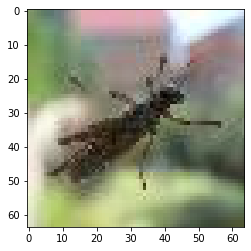

In [9]:
# E.g. visualization of one of the validation set image
import matplotlib.pyplot as plt
arr_ = np.squeeze(x_val[12]) # you can give axis attribute if you wanna squeeze in specific dimension
plt.imshow(arr_)
plt.show()

The new image class is reel


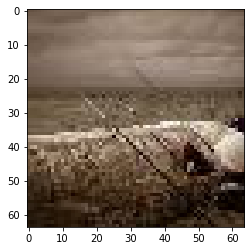

In [10]:
# 3.1
new_class_image = np.squeeze(x_val[1])
print("The new image class is " + class_names[1][0])
plt.imshow(new_class_image)
plt.show()

In [11]:
# To do:  Load the H5 model and print summary. Please make sure the h5 model file is present in the current directory.
# Sample code to load the model
### 3.2
model = tf.keras.models.load_model('/local/Jupyter/cpre482x-lab1/Inference/Template_Jupyter/CNN_tinyimagenet.h5', compile=False)

2021-09-06 15:23:44.400288: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-09-06 15:23:44.423079: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-09-06 15:23:44.423135: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: cpre482-13.ece.iastate.edu
2021-09-06 15:23:44.423146: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: cpre482-13.ece.iastate.edu
2021-09-06 15:23:44.423257: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 470.63.1
2021-09-06 15:23:44.423308: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 470.63.1
2021-09-06 15:23:44.423316: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 470.63.1
2021-09-06 15:23:44.423785: I 

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 60, 60, 32)        2432      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 56, 56, 32)        25632     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 26, 26, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 10, 10, 64)        3

![title](../../ComputationalGraph.png)

In [13]:
# To do: Calculate Top-1, Top-5 accuracy on the validation set
# E.g. to calculate Top-10 accuracy
# Top-10 acc

#3.3
acc_top10=0
for i in range(10000):
    t=x_val[i].reshape(1,64,64,3)
    y_pred= model.predict(t)
    y_true= np.argmax(y_val[i])
    S=tf.math.top_k(
    y_pred, k=10, sorted=True, name=None)
    z=(S.indices.numpy())
    if(y_true in z):
        acc_top10=acc_top10+1
        
print("Top ten Accuracy " + str(acc_top10/10000))

acc_top5=0
for i in range(10000):
    t=x_val[i].reshape(1,64,64,3)
    y_pred= model.predict(t)
    y_true= np.argmax(y_val[i])
    S=tf.math.top_k(
    y_pred, k=5, sorted=True, name=None)
    z=(S.indices.numpy())
    if(y_true in z):
        acc_top5=acc_top5+1

print("Top five Accuracy " + str(acc_top5/10000))        

acc_top1=0
for i in range(10000):
    t=x_val[i].reshape(1,64,64,3)
    y_pred= model.predict(t)
    y_true= np.argmax(y_val[i])
    S=tf.math.top_k(
    y_pred, k=1, sorted=True, name=None)
    z=(S.indices.numpy())
    if(y_true in z):
        acc_top1=acc_top1+1

print("Top one Accuracy " + str(acc_top1/10000))

2021-09-06 15:23:44.606224: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


Top ten Accuracy0.6195
Top five Accuracy0.4965
Top one Accuracy0.242


In [14]:
#Print all the 200 classes present and create three test images each of size 64*64*3 and
#mark the y- value with expected label.
or i in class_names:
    print(i[0])

Egyptian cat
reel
volleyball
rocking chair
lemon
bullfrog
basketball
cliff
espresso
plunger
parking meter
German shepherd
dining table
monarch
brown bear
school bus
pizza
guinea pig
umbrella
organ
oboe
maypole
goldfish
potpie
hourglass
seashore
computer keyboard
Arabian camel
ice cream
nail
space heater
cardigan
baboon
snail
coral reef
albatross
spider web
sea cucumber
backpack
Labrador retriever
pretzel
king penguin
sulphur butterfly
tarantula
lesser panda
pop bottle
banana
sock
cockroach
projectile
beer bottle
mantis
freight car
guacamole
remote control
European fire salamander
lakeside
chimpanzee
pay-phone
fur coat
alp
lampshade
torch
abacus
moving van
barrel
tabby
goose
koala
bullet train
CD player
teapot
birdhouse
gazelle
academic gown
tractor
ladybug
miniskirt
golden retriever
triumphal arch
cannon
neck brace
sombrero
gasmask
candle
desk
frying pan
bee
dam
spiny lobster
police van
iPod
punching bag
beacon
jellyfish
wok
potter's wheel
sandal
pill bottle
butcher shop
slug
hog
couga

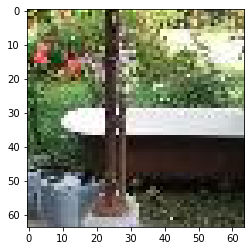

Datatype of the image is: <class 'numpy.ndarray'>
Dimensions of the image is : (64, 64, 3)
Memory usage of the image is 49152
The actual class is ['bathtub', 'bathing tub', 'bath', 'tub']
The predicted class is ['dining table', 'board']


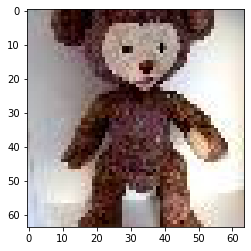

Datatype of the image is: <class 'numpy.ndarray'>
Dimensions of the image is : (64, 64, 3)
Memory usage of the image is 49152
The actual class is ['teddy', 'teddy bear']
The predicted class is ['poncho']


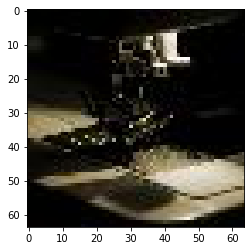

Datatype of the image is: <class 'numpy.ndarray'>
Dimensions of the image is : (64, 64, 3)
Memory usage of the image is 49152
The actual class is ['sewing machine']
The predicted class is ['drumstick']


In [31]:
# To do: Print and visualize three inputs from the validation set. As an example, you may pick x_val[1], x_val[2] and x_val[3]
# To do: Print the data type
# To do: Print and note the dimensions of each image
# To do: Print the memory required to store each image 
index_list = [4,5,6]
for val_index in index_list:
    arr_ = np.squeeze(x_val[val_index])
    plt.imshow(arr_)
    plt.show()
    
    #print data type
    print ("Datatype of the image is: " + str(type(x_val[val_index])))
    #print the dimensions
    print("Dimensions of the image is : " + str(x_val[val_index].shape))
    #print the memory
    print("Memory usage of the image is " + str(x_val[val_index].size * x_val[val_index].itemsize))
    #Print the predicted Class
    pred = model.predict(x_val[val_index].reshape(1,64,64,3))
    #Print the actual class
    y_true= np.argmax(y_val[val_index])
    y_pred = np.argmax(pred)
    print("The actual class is " + str(class_names[y_true]))
    print("The predicted class is " + str(class_names[y_pred]))

<table>
<tr>
    <th>True Classes</th>
    <th>Model Predicted Classes</th>
    <th>Match?</th> 
</tr>



<tr>
    <td>['bathtub', 'bathing tub', 'bath', 'tub']</td> 
    <td>['dining table', 'board']</td> 
    <td>No</td>   
</tr>
<tr>
    <td> ['teddy', 'teddy bear']</td> 
    <td> ['poncho']</td> 
    <td>No</td>   
</tr>
    <tr>
    <td> ['sewing machine']</td> 
    <td> ['drumstick']</td> 
    <td>No</td>   
</tr>
</table>

In [16]:
# To do:  Export each of the three inputs to a binary file which will be used to load later in a C program.
# Example code to export x_val[0] to a binary file:

# Load in a numpy array. # we flatten the array before exporting to binary file. So 64*64*3= 12288 elements 1d array
# NOTE *** So we must reshape before loading in a C program

# inp= np.asarray(x_val[0].flatten())

# # Save in a binary file i.e. numpy.ndarray.to_file()

# f_input=open("input.bin","wb")
# inp.tofile(f_input)
# f_input.close()
index_list = [3,4,5]
for val_index in index_list:
    inp= np.asarray(x_val[val_index].flatten())
    filename = 'input' + str(val_index) + '.bin'
    f_input=open(filename, "wb")
    inp.tofile(f_input)
    f_input.close


#State the different types of layers present in the neural network and write the mathemat-
#ical formulation of each layer type
where n is the batch size, m is the number of filters, c is the number of channels, r/s is filter size h/w, b is the bias term,U is the stride F is the filter weight at mcrs, I is the input feature map.
#Conv2D
O_nmpq = (\sum_crs I_nc(Up + r)(Uq + s) F_mcrs) +b_m

#MaxPooling2D
#same idea as conv except the F is replaced by the maximum value instead of the filter being applied
O_nmpq = (\sum_crs I_nc(Up + r)(Uq + s) F_mcrs) +b_m

#Dense aka fully connected
O_nm = \sum_chw I_nchq F_mchw
or replacing c = 1
O_nm = \sum_hw I_nhq F_mhw

{'name': 'conv2d', 'trainable': True, 'batch_input_shape': (None, 64, 64, 3), 'dtype': 'float32', 'filters': 32, 'kernel_size': (5, 5), 'strides': (1, 1), 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': (1, 1), 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'class_name': 'GlorotUniform', 'config': {'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}
Layer datatype float32
weight dim (5, 5, 3, 32)
9600 bytes
(5, 5)


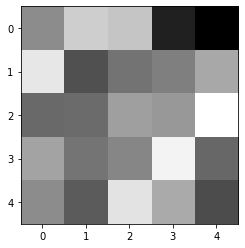


{'name': 'conv2d_1', 'trainable': True, 'dtype': 'float32', 'filters': 32, 'kernel_size': (5, 5), 'strides': (1, 1), 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': (1, 1), 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'class_name': 'GlorotUniform', 'config': {'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}
Layer datatype float32
weight dim (5, 5, 32, 32)
102400 bytes
(5, 5)


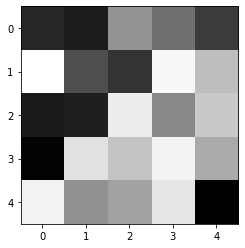


{'name': 'max_pooling2d', 'trainable': True, 'dtype': 'float32', 'pool_size': (2, 2), 'padding': 'valid', 'strides': (2, 2), 'data_format': 'channels_last'}
{'name': 'conv2d_2', 'trainable': True, 'dtype': 'float32', 'filters': 64, 'kernel_size': (3, 3), 'strides': (1, 1), 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': (1, 1), 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'class_name': 'GlorotUniform', 'config': {'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}
Layer datatype float32
weight dim (3, 3, 32, 64)
73728 bytes
(3, 3)


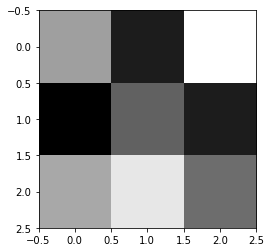


{'name': 'conv2d_3', 'trainable': True, 'dtype': 'float32', 'filters': 64, 'kernel_size': (3, 3), 'strides': (1, 1), 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': (1, 1), 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'class_name': 'GlorotUniform', 'config': {'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}
Layer datatype float32
weight dim (3, 3, 64, 64)
147456 bytes
(3, 3)


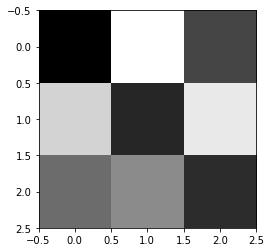


{'name': 'max_pooling2d_1', 'trainable': True, 'dtype': 'float32', 'pool_size': (2, 2), 'padding': 'valid', 'strides': (2, 2), 'data_format': 'channels_last'}
{'name': 'conv2d_4', 'trainable': True, 'dtype': 'float32', 'filters': 64, 'kernel_size': (3, 3), 'strides': (1, 1), 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': (1, 1), 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'class_name': 'GlorotUniform', 'config': {'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}
Layer datatype float32
weight dim (3, 3, 64, 64)
147456 bytes
(3, 3)


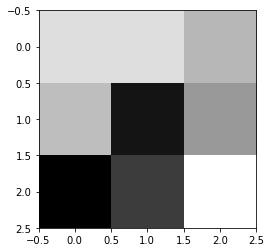


{'name': 'conv2d_5', 'trainable': True, 'dtype': 'float32', 'filters': 128, 'kernel_size': (3, 3), 'strides': (1, 1), 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': (1, 1), 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'class_name': 'GlorotUniform', 'config': {'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}
Layer datatype float32
weight dim (3, 3, 64, 128)
294912 bytes
(3, 3)


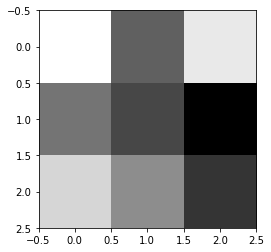


{'name': 'max_pooling2d_2', 'trainable': True, 'dtype': 'float32', 'pool_size': (2, 2), 'padding': 'valid', 'strides': (2, 2), 'data_format': 'channels_last'}
{'name': 'flatten', 'trainable': True, 'dtype': 'float32', 'data_format': 'channels_last'}
{'name': 'dense', 'trainable': True, 'dtype': 'float32', 'units': 256, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'class_name': 'GlorotUniform', 'config': {'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}
Layer datatype float32
weight dim (2048, 256)
2097152 bytes
(2048, 256)


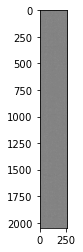


{'name': 'dense_1', 'trainable': True, 'dtype': 'float32', 'units': 200, 'activation': 'softmax', 'use_bias': True, 'kernel_initializer': {'class_name': 'GlorotUniform', 'config': {'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}
Layer datatype float32
weight dim (256, 200)
204800 bytes
(256, 200)


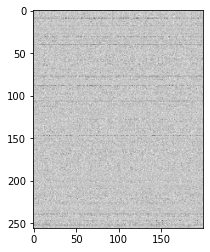

In [89]:
# To do: Print/Visualize weights of all the layers.

for layer in model.layers:
    print(layer.get_config())
    if(layer.get_weights()):
        # To do: Print the data type
        print("Layer datatype", layer.get_weights()[0].dtype)
        
        # To do: Print and note the dimensions of weights of each layer
        print("weight dim", layer.kernel.shape)
        # To do: Print the memory required to store the weights of each layer
        print(layer.kernel.numpy().size * layer.kernel.numpy().itemsize, "bytes")
        #visualize
        if(len(layer.kernel.numpy().shape) == 4):
            arr_ = layer.kernel.numpy()[:, :, 0, 0]
        else:
            arr_ = layer.kernel.numpy()
        print(arr_.shape)
        plt.imshow(arr_, cmap='gray')
        plt.show()
        print( "")

   



In [80]:
# To do:  (Similar to input ) Export all of the weights to a binary file which will be used to load later in a C program and use in the custom C/C++ inference implementation.


In [19]:
# To do: Print/Visualize the intermediate feature maps for all of the layers for all three inputs.

# To do: Print the data type
# To do: Print and note the dimensions of intermediate feature maps of each layer
# To do: Print the memory required to store the intermediate feature maps of each layer

In [20]:
# To do:  (Similar to input ) Export all of the intermediate feature maps for all three inputs to a binary file which will be used to load later in a C program and validate custom C/C++ inference implementation.